In [1]:
from ocsmesh import Raster, Geom, Hfun, Mesh, JigsawDriver, utils
import geopandas as gpd

In [2]:
import jigsawpy

In [3]:
from shapely.ops import unary_union
import pyproj
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from copy import deepcopy
from matplotlib.tri import Triangulation

In [81]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
cb = gpd.read_file('CB_coast.shp')

In [6]:
crs_4326 = pyproj.CRS.from_epsg(4326)
crs_3112 = pyproj.CRS.from_epsg(3112) # GDA94 / Geoscience Australia Lambert projected coordinates

In [7]:
files ='roi.shp'
roi = gpd.read_file(files)
cb = cb.clip(roi.geometry[0])

In [8]:
roi

,FID,geometry
0,0,"POLYGON ((115.73951 -32.07771, 115.73772 -32.0..."


In [9]:
cb

,FID,geometry
0,1,"MULTIPOLYGON (((115.75129 -32.07724, 115.75129..."
10,11,"POLYGON ((115.90805 -32.03190, 115.90811 -32.0..."
11,12,"POLYGON ((115.91183 -32.03170, 115.91173 -32.0..."
12,13,"POLYGON ((115.90429 -32.03006, 115.90422 -32.0..."
15,16,"POLYGON ((115.88766 -31.96243, 115.88771 -31.9..."
16,17,"POLYGON ((115.91173 -31.93657, 115.91178 -31.9..."
17,18,"POLYGON ((115.91077 -31.93706, 115.91080 -31.9..."
18,19,"POLYGON ((115.94034 -31.92242, 115.94029 -31.9..."


In [10]:
cb.crs = "EPSG:4326"  # WGS84

In [11]:
cbm = cb.to_crs(crs_3112)  # into UTM

In [12]:
min_island_area = 1e4 # filter out small islands
mask = cbm.area > min_island_area
cbm2 = cbm
cbm2 = cbm2.loc[mask]

In [13]:
cbm2

,FID,geometry
0,1,"MULTIPOLYGON (((-1702262.788 -3741152.263, -17..."
15,16,"POLYGON ((-1691442.978 -3726821.514, -1691437...."
16,17,"POLYGON ((-1689618.814 -3723684.277, -1689613...."
17,18,"POLYGON ((-1689700.277 -3723750.649, -1689695...."
18,19,"POLYGON ((-1687187.740 -3721760.527, -1687191...."


In [14]:
roi.crs = "EPSG:4326"  # WGS84 

In [15]:
roim = roi.to_crs(crs_3112) # in meters UTM

In [82]:
domain = roim['geometry'].subtract(cbm2.unary_union)  # this is in meters

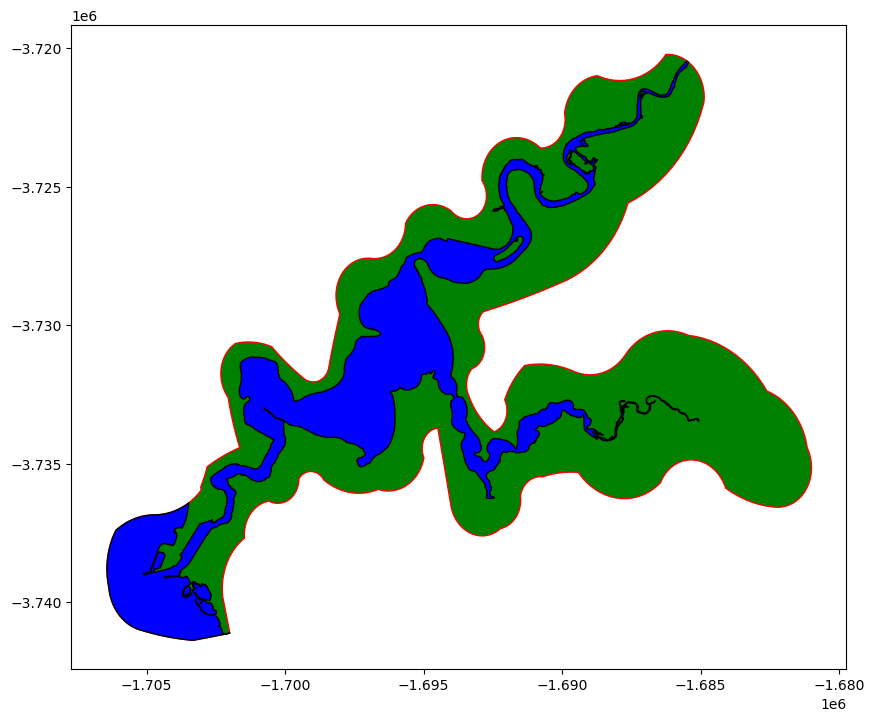

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
roim.plot(ax=ax, color='green', edgecolor='red')
domain.plot(ax=ax, color='blue', edgecolor='black');

In [18]:
domainll = domain.to_crs(crs_4326) # back in WGS84 lon lat

<Axes: >

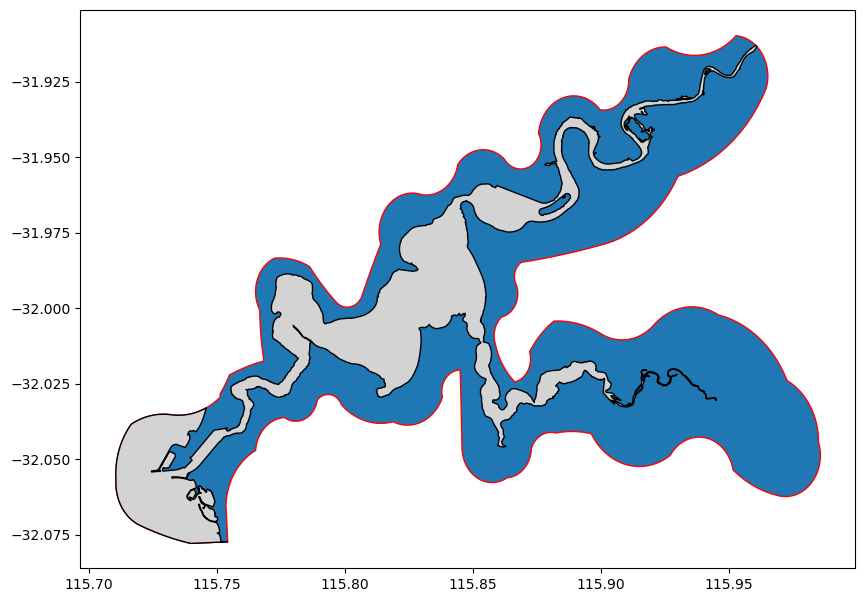

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
roi.plot(ax=ax, color=None, edgecolor='red');
domainll.plot(ax=ax, color='lightgray', edgecolor='black')

In [21]:
rasters = [Raster('swan_topo.nc'), Raster('Freo_lidar_0.5s.nc')]

In [83]:
geom = Geom(
    deepcopy(rasters),
    zmax=25,
    base_shape=roim.unary_union,
    base_shape_crs=roim.crs,
)

domain_poly = geom.get_multipolygon()

In [84]:
geom.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

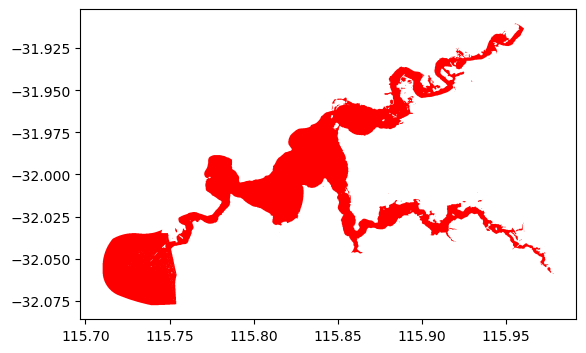

In [85]:
fig, ax = plt.subplots(1, 1)
gpd.GeoSeries(domain_poly).plot(ax=ax, color='r')
ax.set_aspect(1)


In [86]:
gdf_polys = gpd.GeoDataFrame(geometry=[domain_poly], crs=geom.crs).explode(ignore_index=True)
gdf_main = gpd.GeoDataFrame(geometry=gdf_polys.iloc[gdf_polys.area.argmax()])

geom_main = Geom(gdf_main.unary_union, crs=gdf_main.crs)

In [87]:
# refinement along coast
coast = gpd.read_file('geometry2.shp')
coast.crs='epsg:4326'

In [88]:
import time
def resample_coastline(coast, distance):
    '''
    coastline should be in WGS84 (lon, lat) projection and loaded as:
    coast = gpd.read_file('coastline.shp')
    distance is in meters
    
    returns sampled points along the coast with the distance btw points defined with distance
    
    call as:
    lon, lat, x_m, y_m = resample_coastline(coast, distance)
    
    
    '''
    start = time.time()
    crs_4326 = pyproj.CRS.from_epsg(4326)
    crs_3112 = pyproj.CRS.from_epsg(3112) # GDA94 / Geoscience Australia Lambert projected coordinates
    mcoast = coast.to_crs(crs_3112)
    tmp = mcoast.geometry[0]
    if (tmp.length > 2*distance):
        distances = np.arange(0, tmp.length, distance)
        try:
            points = [tmp.interpolate(distance) for distance in distances] + [tmp.boundary[0]]
        except:
            points = [tmp.interpolate(distance) for distance in distances]
        multipoint = unary_union(points)
    else:
        print('coastline to short')
        return
    print('Done with point interpolations')    
    gdm = gpd.GeoDataFrame({'geometry': [multipoint]}, crs=3112)
    a = gdm.explode(index_parts=True)
    x_m = np.array(a.geometry.x).tolist() 
    y_m = np.array(a.geometry.y).tolist()
    print('Done with points mapping to crs 3112')
    gdp = gdm.to_crs(crs_4326)
    print('Done with points mapping to WGS84')
    a = gdp.explode(index_parts=True)
    x = np.array(a.geometry.x).tolist() 
    y = np.array(a.geometry.y).tolist()
    print('Done in %f seconds' %(time.time()-start))
    
    return x, y, x_m, y_m 
    

In [89]:
x, y, xm, ym = resample_coastline(coast, 50)  # resample roads multilinestring with 50m resolution (need for fixed points)

Done with point interpolations
Done with points mapping to crs 3112
Done with points mapping to WGS84
Done in 1.534263 seconds


In [90]:
# create lists of points (WGS and in meters)
list_points = []
for i in range(0, len(x)):
    list_points.append((x[i], y[i]))
    
list_points_m = []
for i in range(0, len(xm)):
    list_points_m.append((xm[i], ym[i]))

In [93]:
hfun = Hfun(
    deepcopy(rasters),
    hmin=10,
    hmax=500,
    base_shape=domain.unary_union,
    base_shape_crs=domain.crs
)

hfun.add_constant_value(500, lower_bound=2)
hfun.add_constant_value(200, lower_bound=1)

hfun.add_contour(
    level=-5,
    target_size=50,
    expansion_rate=0.002,
)

hfun.add_contour(
    level=-10,
    target_size=100,
    expansion_rate=0.001,
)

In [92]:
# Refine along the coastline, not using as I will fix the points
# hfun.add_feature(coast.unary_union,
#                  expansion_rate = 0.01,
#                  target_size = 10)

In [94]:
geom_jig = geom.msh_t()

In [95]:
hfun_jig = hfun.msh_t()

In [96]:
geom_jig.crs

<Projected CRS: +proj=utm +zone=50 +south +ellps=WGS84 +type=crs>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 50S
- method: Transverse Mercator
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [97]:
hfun_jig.crs

<Projected CRS: +proj=utm +zone=50 +south +ellps=WGS84 +type=crs>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 50S
- method: Transverse Mercator
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

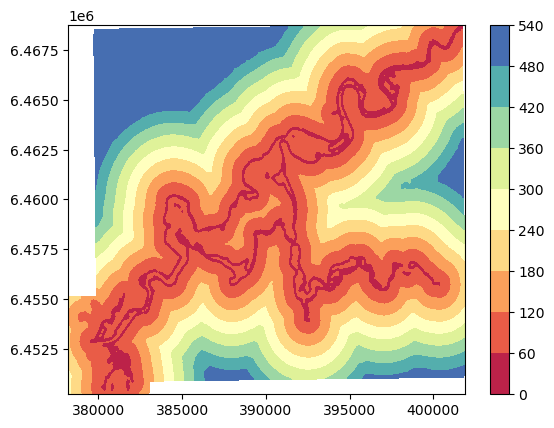

In [98]:
fig, ax = plt.subplots(1, 1)
plt.tricontourf(
    Triangulation(
        hfun_jig.vert2['coord'][:, 0],
        hfun_jig.vert2['coord'][:, 1],
        triangles=hfun_jig.tria3['index']
    ),
    hfun_jig.value.flatten(),cmap='Spectral'
)
plt.colorbar();

In [99]:
driver = JigsawDriver(geom_main, hfun, initial_mesh=False)
mesh = driver.run()

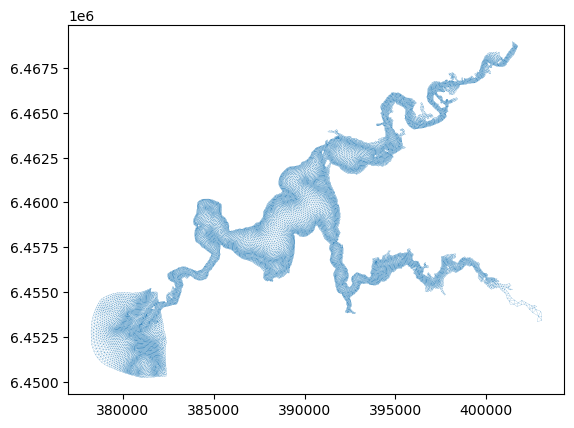

In [100]:
%matplotlib inline
plt.triplot(
    mesh.msh_t.vert2['coord'][:, 0],
    mesh.msh_t.vert2['coord'][:, 1],
    triangles=mesh.msh_t.tria3['index'],
    lw=0.1
);

In [101]:
np.shape(mesh.coord)

(20005, 2)

In [ ]:
# Now try to add coastline points as a fixed points in the jig

In [102]:
opts = jigsawpy.jigsaw_jig_t()
opts.hfun_scal = "absolute"
opts.hfun_hmin = np.min(hfun_jig.value)
opts.hfun_hmax = np.max(hfun_jig.value)
opts.mesh_dims = +2

In [108]:
# Initial mesh (e.g. points you'd like to embed in final mesh)  
# WGS84 or UTM ? 
embedding_points_xy = list_points_m  # List of (x,y) values for the points of interest _m in UTM
init_jig = jigsawpy.jigsaw_msh_t()
init_jig.mshID = 'euclidean-mesh'
init_jig.ndims = 2
init_jig.crs = hfun_jig.crs
init_jig.vert2 = np.array(
    [(coord, -1) for coord in embedding_points_xy],
    dtype=jigsawpy.jigsaw_msh_t.VERT2_t
)

In [109]:
init_jig.vert2

array([([115.72430624, -32.05370695], -1),
       ([115.72432638, -32.05407074], -1),
       ([115.72483088, -32.05365289], -1), ...,
       ([115.94448536, -32.02957693], -1),
       ([115.94474533, -32.0299653 ], -1),
       ([115.94467467, -32.03039211], -1)],
      dtype={'names': ['coord', 'IDtag'], 'formats': [('<f8', (2,)), '<i4'], 'offsets': [0, 16], 'itemsize': 24, 'aligned': True})

In [110]:
# Empty mesh object
mesh_jig= jigsawpy.jigsaw_msh_t()
mesh_jig.mshID = 'euclidean-mesh'
mesh_jig.ndims = 2
mesh_jig.crs = init_jig.crs

In [111]:
jigsawpy.lib.jigsaw(
    opts, geom_jig, mesh_jig,
    init=init_jig,
    hfun=hfun_jig)

In [112]:
utils.finalize_mesh(mesh_jig, sieve_area=None)

ValueError: zero-size array to reduction operation maximum which has no identity

In [51]:
mesh2 = Mesh(mesh_jig)

In [52]:
mesh2.coord

array([], shape=(0, 2), dtype=float64)